# Dense Neural Network (NN) Exploration

In this notebook, we will lay out our approach for a Neural Network approach to predict a pose based on landmark. Additionally, we are storing out angle calculation and perspectively our angle error calculation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Neural Network

In [2]:
import tensorflow as tf


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models


In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import load_model
import joblib


In [5]:
from scipy.stats import uniform


In [6]:
# Load the datasets
train_df = pd.read_csv('train_landmark_xy_raw.csv')
val_df = pd.read_csv('val_landmark_xy_raw.csv')
test_df = pd.read_csv('test_landmark_xy_raw.csv')


In [7]:
# Define X_train and y_train
X_train = train_df.iloc[:, 1:35]
y_train = train_df['y_sub']


In [8]:
# Define X_val and y_val
X_val = val_df.iloc[:, 1:35]
y_val = val_df['y_sub']


In [9]:
# Define X_test and y_test
X_test = test_df.iloc[:, 1:35]
y_test = test_df['y_sub']


In [10]:
# Convert labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])


In [11]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [13]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric)
y_val_one_hot = to_categorical(y_val_numeric)
y_test_one_hot = to_categorical(y_test_numeric)

encoder = OneHotEncoder()

# Saving the encoder
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

In [14]:
# Build the neural network model
def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = initialize_model()


2023-11-27 11:16:19.081418: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-27 11:16:19.081477: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-27 11:16:19.081514: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-27 11:16:19.081872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 11:16:19.082338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[es])


Epoch 1/100
 1/17 [>.............................] - ETA: 6s - loss: 2.4834 - accuracy: 0.0938

2023-11-27 11:16:34.711990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-27 11:16:34.730603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


17/17 [==============================] - 1s 25ms/step - loss: 2.1488 - accuracy: 0.2056 - val_loss: 1.5808 - val_accuracy: 0.5764
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 1.6501 - accuracy: 0.4093 - val_loss: 1.3296 - val_accuracy: 0.5694
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 1.3943 - accuracy: 0.5402 - val_loss: 1.1204 - val_accuracy: 0.6667
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 1.2424 - accuracy: 0.5701 - val_loss: 0.9678 - val_accuracy: 0.7639
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 1.1135 - accuracy: 0.6280 - val_loss: 0.8690 - val_accuracy: 0.8194
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 1.0316 - accuracy: 0.6262 - val_loss: 0.7742 - val_accuracy: 0.7917
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.9553 - accuracy: 0.6542 - val_loss: 0.7144 - val_accuracy: 0.8194
Epoch 8/100
17/17 

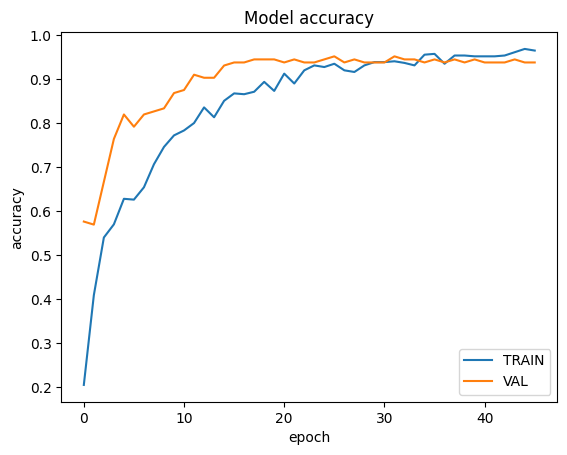

In [17]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


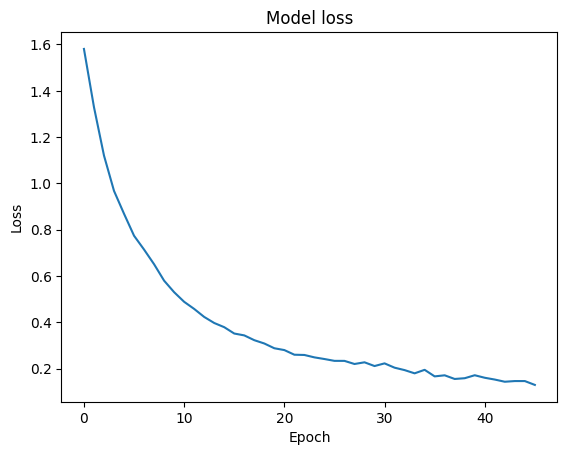

In [18]:
def plot_history(history):
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)


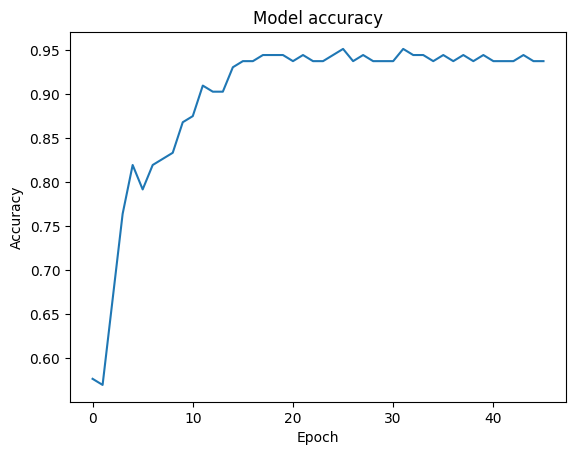

In [19]:
def plot_history_accuracy(history):
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_history_accuracy(history)


In [22]:
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_numeric)

# Evaluate the model on the test set
results = model.evaluate(X_test, y_test_one_hot, verbose=0)


In [23]:
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')


Test Accuracy: 95.45%
Test Loss: 0.18202415108680725


In [24]:
X_pred = X_test[-1].reshape(1,-1)


In [25]:
%time
prediction = model.predict(X_pred)


CPU times: user 2 µs, sys: 18 µs, total: 20 µs
Wall time: 24.1 µs
1/1 [==============================] - 0s 89ms/step


2023-11-27 11:18:05.544075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


In [26]:
predict_class = np.argmax(prediction, axis = 1)
predict_class


array([7])

In [27]:
predicted_labels = np.argmax(prediction, axis=1)


In [28]:
predicted_class_names = [class_name for class_name, idx in label_mapping.items() if idx in predict_class]
predicted_class_names[0]


'warrior2_right'

In [30]:
model.save('24112023_sub_model.h5')  # Save the entire model
